Based on:

@book{leborgne2022fraud,

title={Reproducible Machine Learning for Credit Card Fraud Detection - Practical Handbook},

author={Le Borgne, Yann-A{\"e}l and Siblini, Wissam and Lebichot, Bertrand and Bontempi, Gianluca},

url={https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook},

year={2022},

publisher={Universit{\'e} Libre de Bruxelles}

}

Covered subchapters:
* 6.4 Ensemble learning

In [1]:
import datetime
import sklearn
import time
import pickle
import imblearn
import pandas as pd
import wandb

In [2]:
%run ../shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63257  100 63257    0     0   171k      0 --:--:-- --:--:-- --:--:--  171k


In [3]:
%run ../my_shared_functions.py

In [4]:
DIR_INPUT = '../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


n_folds = 4

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'f1_score', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'f1_score': 'f1',
           'card_precision@100': card_precision_top_100,
           }

Load  files
CPU times: total: 625 ms
Wall time: 570 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [5]:
classifier = sklearn.ensemble.BaggingClassifier()

parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__bootstrap':[True],
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_bagging = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_bagging=performances_df

In [6]:
summary_performances_bagging = get_summary_performances_f1_included(performances_df_baseline_bagging, parameter_column_name="Parameters summary")
summary_performances_bagging

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,100,100,100,100
Validation performance,0.872+/-0.01,0.704+/-0.01,0.744+/-0.01,0.284+/-0.01
Test performance,0.856+/-0.02,0.678+/-0.01,0.733+/-0.01,0.293+/-0.01
Optimal parameter(s),100,100,100,100
Optimal test performance,0.856+/-0.02,0.678+/-0.01,0.733+/-0.01,0.293+/-0.01


In [9]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = sklearn.ensemble.BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0),
                                                n_estimators=100, random_state=0, n_jobs=-1)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_not_considered/bagging_dt/bagging_dt_maxdepth20_nestimators100_model.sav', 'wb'))

In [10]:
config_bagging = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    dt_random_state = 0,
    bagging_random_state = 0,
    max_depth = 20,
    n_estimators = 100,
    scale = True,
    n_jobs = -1
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_bagging, tags=['bagging', 'decision-tree', 'imbalance-not-considered'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

bagging_artifact = wandb.Artifact('bagging_dt', type='bagging', description='trained bagging with decision trees as estimators')
bagging_artifact.add_dir('../models/ML_imbalance_not_considered/bagging_dt')
wandb.log_artifact(bagging_artifact)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (.\models\ML_imbalance_not_considered\bagging_dt)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.856
Average precision,0.663
Card Precision@100,0.283
F1 score,0.719
Prediction execution time,0.332


In [11]:
classifier = sklearn.ensemble.RandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_rf=performances_df

In [12]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_baseline_xgboost = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__n_estimators'] for i in range(len(parameters_dict))]

performances_df_baseline_xgboost=performances_df

In [13]:
summary_performances_baseline_bagging=get_summary_performances_f1_included(performances_df_baseline_bagging, parameter_column_name="Parameters summary")
summary_performances_baseline_rf=get_summary_performances_f1_included(performances_df_baseline_rf, parameter_column_name="Parameters summary")
summary_performances_baseline_xgboost=get_summary_performances_f1_included(performances_df_baseline_xgboost, parameter_column_name="Parameters summary")
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Baseline RF', 'Baseline XGBoost']
summary_test_performances

,Baseline Bagging,Baseline RF,Baseline XGBoost
AUC ROC,0.856+/-0.02,0.87+/-0.02,0.872+/-0.01
Average precision,0.678+/-0.01,0.678+/-0.01,0.687+/-0.01
F1 score,0.733+/-0.01,0.703+/-0.03,0.722+/-0.02
Card Precision@100,0.293+/-0.01,0.299+/-0.01,0.302+/-0.01


##### Balanced bagging

In [24]:
classifier = imblearn.ensemble.BalancedBaggingClassifier()

parameters = {'clf__base_estimator':[sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0)], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.02, 0.05, 0.1, 0.5, 1], 
              'clf__bootstrap':[True],
              'clf__sampler':[imblearn.under_sampling.RandomUnderSampler()],
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_balanced_bagging = time.time()-start_time

In [25]:
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_balanced_bagging=performances_df

In [26]:
summary_performances_balanced_bagging = get_summary_performances_f1_included(performances_df_balanced_bagging, parameter_column_name="Parameters summary")
summary_performances_balanced_bagging

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,0.5,0.02,0.02,0.1
Validation performance,0.88+/-0.0,0.704+/-0.01,0.746+/-0.01,0.289+/-0.02
Test performance,0.879+/-0.01,0.68+/-0.01,0.732+/-0.02,0.305+/-0.01
Optimal parameter(s),0.5,0.02,0.02,0.5
Optimal test performance,0.879+/-0.01,0.68+/-0.01,0.732+/-0.02,0.305+/-0.01


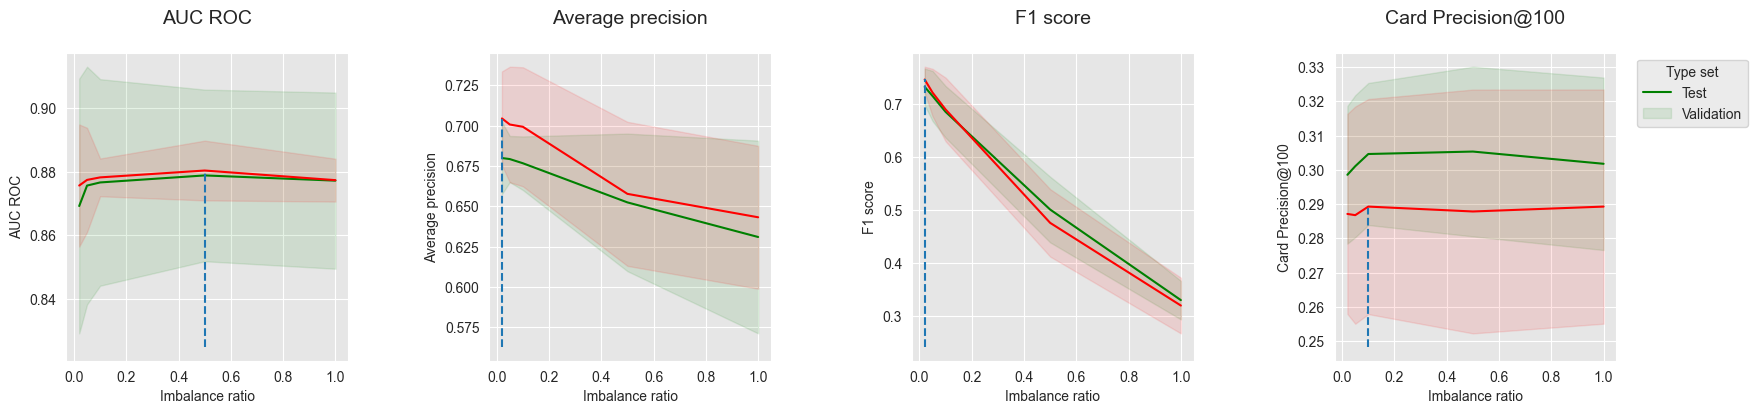

In [27]:
get_performances_plots(performances_df_balanced_bagging, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_bagging)

In [28]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)

classifier = imblearn.ensemble.BalancedBaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=20,random_state=0),
                                                n_estimators=100, sampling_strategy=0.1, sampler=imblearn.under_sampling.RandomUnderSampler(random_state=0),
                                                random_state=0, n_jobs=-1)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_considered/bagging_dt_randunder/bagging_dt_maxdepth20_nestimators100_randundersampl0dot1_model.sav', 'wb'))

In [29]:
config_balanced_bagging = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    dt_random_state = 0,
    bagging_random_state = 0,
    max_depth = 20,
    n_estimators = 100,
    scale = True,
    n_jobs = -1,
    randomundersampler_sampling_strategy = 0.1,
    randomundersampler_random_state = 0,
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_balanced_bagging, tags=['bagging', 'decision-tree', 'imbalance-considered', 'hypertuned'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

bagging_artifact = wandb.Artifact('bagging_dt_randunder', type='bagging', description='trained bagging with decision trees as estimators and random undersampler')
bagging_artifact.add_dir('../models/ML_imbalance_considered/bagging_dt_randunder')
wandb.log_artifact(bagging_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_considered\bagging_dt_randunder)... Done. 0.0s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.871
Average precision,0.665
Card Precision@100,0.294
F1 score,0.692
Prediction execution time,0.347


##### Balanced Random Forest

In [30]:
classifier = imblearn.ensemble.BalancedRandomForestClassifier()

parameters = {'clf__max_depth':[20], 
              'clf__n_estimators':[100],
              'clf__sampling_strategy':[0.01, 0.05, 0.1, 0.5, 1], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_rf_balanced = time.time()-start_time

In [31]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__sampling_strategy'] for i in range(len(parameters_dict))]

performances_df_balanced_rf=performances_df

In [32]:
summary_performances_balanced_rf=get_summary_performances_f1_included(performances_df=performances_df_balanced_rf, parameter_column_name="Parameters summary")
summary_performances_balanced_rf

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,0.05,0.01,0.01,0.05
Validation performance,0.882+/-0.0,0.695+/-0.02,0.721+/-0.03,0.291+/-0.02
Test performance,0.872+/-0.02,0.677+/-0.01,0.705+/-0.03,0.302+/-0.01
Optimal parameter(s),0.5,0.01,0.01,0.01
Optimal test performance,0.876+/-0.01,0.677+/-0.01,0.705+/-0.03,0.304+/-0.01


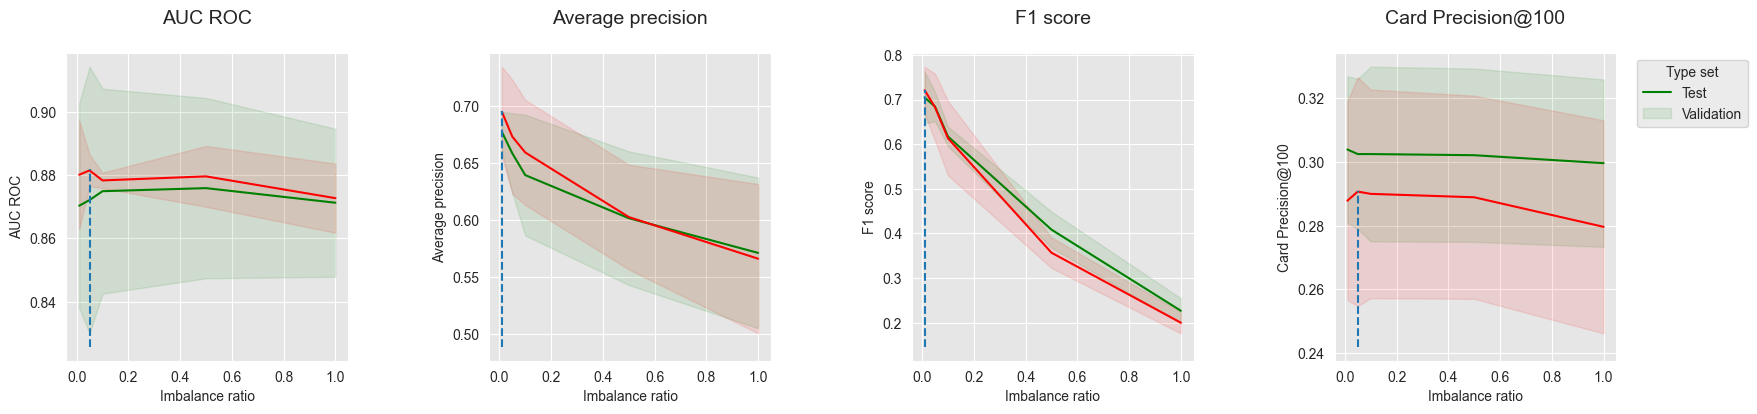

In [33]:
get_performances_plots(performances_df_balanced_rf, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'F1 score', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Imbalance ratio",
                       summary_performances=summary_performances_balanced_rf)

In [34]:
(train_df, test_df) = get_train_test_set(transactions_df,start_date_training+datetime.timedelta(days=delta_train+delta_delay),
                                       delta_train=7,delta_delay=7,delta_test=7)


classifier = imblearn.ensemble.BalancedRandomForestClassifier(max_depth=20, n_estimators=100, sampling_strategy=0.05, random_state=0, n_jobs=-1)
model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=True)
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
pickle.dump(classifier, open('../models/ML_imbalance_considered/rf_randunder/rf_maxdepth20_nestimators100_randundersampl0dot05_model.sav', 'wb'))

In [36]:
config_rf = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'prequential validation',
    begin_date = '2018-08-08',
    delta_train = 7,
    delta_delay = 7,
    delta_test = 7,
    delta_assessment = 7,
    n_folds = 4,
    rf_random_state = 0,
    max_depth = 20,
    n_estimators = 100,
    scale = True,
    n_jobs = -1,
    randomundersampler_sampling_strategy = 0.05
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config_rf, tags=['random-forest', 'imbalance-considered', 'hypertuned'])
wandb.log({'Training execution time': model_and_predictions_dictionary['training_execution_time']})
wandb.log({'Prediction execution time':  model_and_predictions_dictionary['prediction_execution_time']})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})

rf_artifact = wandb.Artifact('rf_randunder', type='random_forest', description='trained random forest with random undersampling strategy')
rf_artifact.add_dir('../models/ML_imbalance_considered/rf_randunder')
wandb.log_artifact(rf_artifact)
wandb.finish()

wandb: Adding directory to artifact (.\models\ML_imbalance_considered\rf_randunder)... Done. 0.1s


AUC ROC,▁
Average precision,▁
Card Precision@100,▁
F1 score,▁
Prediction execution time,▁
Training execution time,▁
AUC ROC,0.869
Average precision,0.65
Card Precision@100,0.289
F1 score,0.672
Prediction execution time,0.106


##### Weighted XGBoost

In [37]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[3], 
              'clf__n_estimators':[50],
              'clf__learning_rate':[0.3],
              'clf__scale_pos_weight':[1,5,10,50,100], 
              'clf__random_state':[0],
              'clf__n_jobs':[-1]}

start_time = time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=-1)

execution_time_weighted_xgboost = time.time()-start_time

In [38]:
parameters_dict = dict(performances_df['Parameters'])
performances_df['Parameters summary'] = [parameters_dict[i]['clf__scale_pos_weight'] for i in range(len(parameters_dict))]

performances_df_weighted_xgboost=performances_df

In [39]:
summary_performances_weighted_xgboost=get_summary_performances_f1_included(performances_df=performances_df_weighted_xgboost, parameter_column_name="Parameters summary")
summary_performances_weighted_xgboost

,AUC ROC,Average precision,F1 score,Card Precision@100
Best estimated parameters,1,1,1,5
Validation performance,0.883+/-0.01,0.708+/-0.02,0.749+/-0.01,0.289+/-0.01
Test performance,0.872+/-0.01,0.687+/-0.01,0.722+/-0.02,0.3+/-0.01
Optimal parameter(s),1,1,1,1
Optimal test performance,0.872+/-0.01,0.687+/-0.01,0.722+/-0.02,0.302+/-0.01


For all metrics, increasing the class weight leads to a decrease in performances on the test set

##### Summary

In [40]:
summary_test_performances = pd.concat([summary_performances_baseline_bagging.iloc[2,:],
                                       summary_performances_balanced_bagging.iloc[2,:],
                                       summary_performances_baseline_rf.iloc[2,:],
                                       summary_performances_balanced_rf.iloc[2,:],
                                       summary_performances_baseline_xgboost.iloc[2,:],
                                       summary_performances_weighted_xgboost.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Baseline Bagging', 'Balanced Bagging', 
                                   'Baseline RF', 'Balanced RF', 
                                   'Baseline XGBoost', 'Weighted XGBoost']

In [41]:
summary_test_performances

,Baseline Bagging,Balanced Bagging,Baseline RF,Balanced RF,Baseline XGBoost,Weighted XGBoost
AUC ROC,0.856+/-0.02,0.879+/-0.01,0.87+/-0.02,0.872+/-0.02,0.872+/-0.01,0.872+/-0.01
Average precision,0.678+/-0.01,0.68+/-0.01,0.678+/-0.01,0.677+/-0.01,0.687+/-0.01,0.687+/-0.01
F1 score,0.733+/-0.01,0.732+/-0.02,0.703+/-0.03,0.705+/-0.03,0.722+/-0.02,0.722+/-0.02
Card Precision@100,0.293+/-0.01,0.305+/-0.01,0.299+/-0.01,0.302+/-0.01,0.302+/-0.01,0.3+/-0.01
